In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from datetime import datetime
import torch
from torch import nn 
import torch.nn.functional as F
from torch import utils

torch.manual_seed(0)
np.random.seed(0)

import warnings
warnings.filterwarnings("ignore")

## Task A

In [2]:
train = pd.read_csv("review_train.csv")
test = pd.read_csv("review_test.csv", encoding='ISO-8859-1')
train.head()

,Review_id,Author,Title,Review,Rating,Dates,Restaurant,Location,Category
0,9479176454,"Thiben76Singapore, Singapore",Lou..sy,"Food test is nowhere near the hype, roasted ch...",1 star,Reviewed 8 November 2018,Lou Wong Bean Sprout Chicken,Ipoh,Mexican
1,4091810389,Choi Yee C,no table,"nice place to visit everytime go melaka, not s...",4 star,Reviewed 14 June 2016,Jonker 86 QQ Ice,Melaka,Italian
2,8163808786,Renganathan S,Best food in town,I tried linguine bolognaise sauce... It's very...,5 star,Reviewed 13 September 2013,Gianni's Trattoria,JB,Italian
3,5014720440,"NahneeRolla, Missouri",You decide,The moment we were at the front door the resta...,1 star,Reviewed 2 January 2017,Moghul Mahal Restaurant,KL,Mexican
4,6466234202,"vidyamenonKuala Lumpur, Malaysia",Was in the area...,Was around the area and stopped by to have a d...,4 star,Reviewed 14 April 2018,One Serambi Cafe,Shah Alam,Mediterranean


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10074 entries, 0 to 10073
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Review_id   10074 non-null  int64 
 1   Author      10055 non-null  object
 2   Title       10074 non-null  object
 3   Review      10074 non-null  object
 4   Rating      10074 non-null  object
 5   Dates       10052 non-null  object
 6   Restaurant  10074 non-null  object
 7   Location    10074 non-null  object
 8   Category    10074 non-null  object
dtypes: int64(1), object(8)
memory usage: 708.5+ KB


In [10]:
train["Category"].value_counts()

Fine Dining      2579
Seafood          2056
Italian          1920
Mexican          1761
Mediterranean    1758
Name: Category, dtype: int64

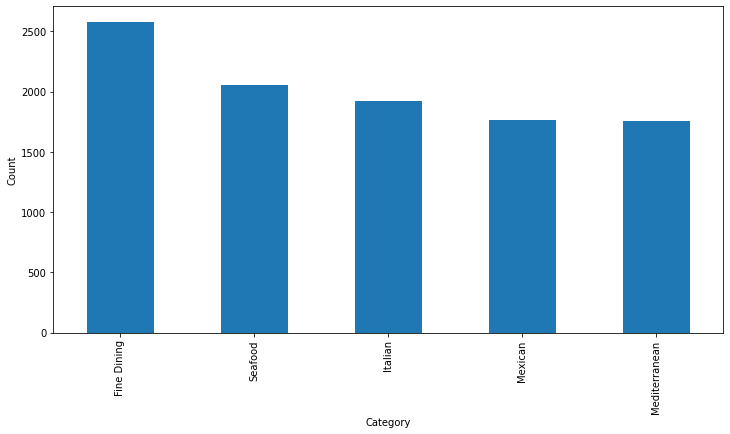

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 6))
train["Category"].value_counts().plot.bar()
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()

In [12]:
train["Rating"].value_counts()

2 star    2174
1 star    2029
5 star    1965
4 star    1954
3 star    1952
Name: Rating, dtype: int64

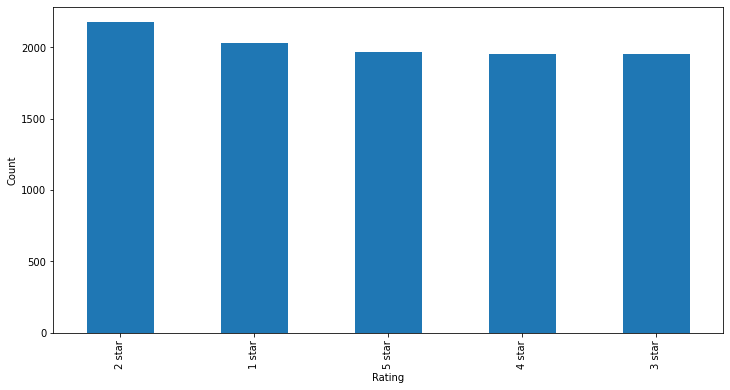

In [15]:
plt.figure(figsize=(12, 6))
train["Rating"].value_counts().plot.bar()
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

In [18]:
train["Location"].value_counts()

KL               5280
Melaka           1166
Penang            656
Kuching           625
JB                611
Langkawi          544
Shah Alam         525
Ipoh              475
Miri              132
Petaling Jaya      60
Name: Location, dtype: int64

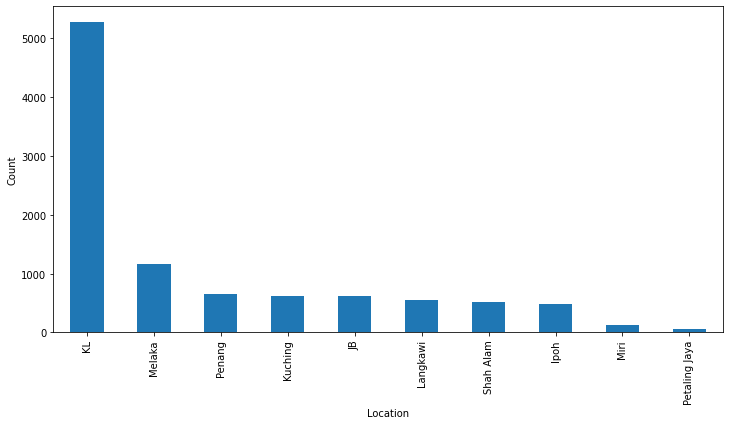

In [19]:
plt.figure(figsize=(12, 6))
train["Location"].value_counts().plot.bar()
plt.xlabel("Location")
plt.ylabel("Count")
plt.show()

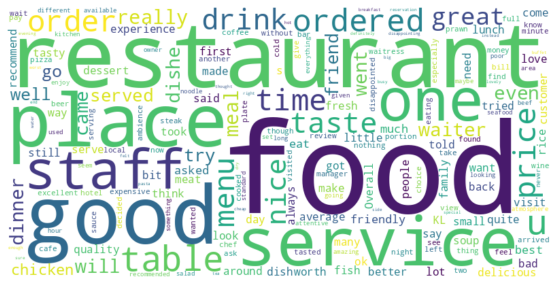

In [28]:
from wordcloud import WordCloud
# Combine all reviews into a single string
text = " ".join(review for review in train.Review)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

The analysis of the restaurant reviews dataset reveals some notable insights about the distribution of categories, ratings, and locations of the reviewed restaurants. The majority of the reviews are for Fine Dining establishments, which account for the largest share with 2,579 reviews, followed by Seafood (2,056), Italian (1,920), Mexican (1,761), and Mediterranean (1,758). This indicates a strong interest and engagement with Fine Dining and Seafood restaurants among the reviewers. When examining the ratings, there is a relatively balanced distribution across the different rating levels, with 2-star reviews being the most common (2,174), followed closely by 1-star (2,029), and 5-star reviews (1,965). This distribution suggests that while there are many highly positive experiences, there are also significant numbers of negative reviews, indicating variability in customer satisfaction.

Geographically, Kuala Lumpur (KL) dominates as the most reviewed location, with 5,280 reviews, which is nearly half of the total dataset. This is followed by Melaka (1,166), Penang (656), Kuching (625), and JB (611), among other locations.

The frequent words "food", "restaurants", "place", "time", "staff", "good", "taste", and "service" suggest that reviewers prioritize the quality and flavor of the food, the behavior and efficiency of the service staff, and the overall dining environment. The emphasis on "food" and "taste" indicates that culinary experience is central, while "service" and "staff" highlight the importance of professional and courteous personnel. Words like "place" and "time" reflect concerns about ambiance and dining logistics. 

In [3]:
test.head()

,Review_id,Author,Title,Review,Dates,Restaurant,Location,Category
0,8932912353,"foodmonstrAuckland, New Zealand",Not upto the mark..very dissapointed,"Well, me and my wife, we both are a huge fan o...",Reviewed 15 December 2013,La Mexicana,KL,Mexican
1,2297453204,"Choonyiap2238Penang Island, Malaysia",super Beautiful and Very Nice,this place will get popular so come before the...,Reviewed 18 January 2020,Puree Juice,Penang,Seafood
2,7566613590,"MikeCMelbourneMelbourne, Australia",Simple place for a Malaysian meal,"Unlike food places in the city, this place is ...",Reviewed 6 November 2018,486 Baba Low,Melaka,Fine Dining
3,3928266447,Climber489653,Cozy,The environment is comfortable and awesome.\nS...,Reviewed 25 August 2018,Relish The Moment,Melaka,Seafood
4,7724170214,yiningl2014,Not recommended,Not nice at all. Super spicy steamboat pasta w...,Reviewed 11 November 2018,Roi Spoon,JB,Mexican


In [4]:
# some basic information
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10074 entries, 0 to 10073
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Review_id   10074 non-null  int64 
 1   Author      10055 non-null  object
 2   Title       10074 non-null  object
 3   Review      10074 non-null  object
 4   Rating      10074 non-null  object
 5   Dates       10052 non-null  object
 6   Restaurant  10074 non-null  object
 7   Location    10074 non-null  object
 8   Category    10074 non-null  object
dtypes: int64(1), object(8)
memory usage: 708.5+ KB


In [5]:
train = train[train['Dates'].notna()]


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10052 entries, 0 to 10073
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Review_id   10052 non-null  int64 
 1   Author      10033 non-null  object
 2   Title       10052 non-null  object
 3   Review      10052 non-null  object
 4   Rating      10052 non-null  object
 5   Dates       10052 non-null  object
 6   Restaurant  10052 non-null  object
 7   Location    10052 non-null  object
 8   Category    10052 non-null  object
dtypes: int64(1), object(8)
memory usage: 785.3+ KB


In [7]:
# This dataset is balanced
print(train[train['Author']== 'CrystalismKuala Lumpur, Malaysia'])

       Review_id                            Author  \
295   6990138392  CrystalismKuala Lumpur, Malaysia   
367   3490723979  CrystalismKuala Lumpur, Malaysia   
650   3277945489  CrystalismKuala Lumpur, Malaysia   
976   6125987377  CrystalismKuala Lumpur, Malaysia   
1309  1935628005  CrystalismKuala Lumpur, Malaysia   
2189  3563184616  CrystalismKuala Lumpur, Malaysia   
2550  6849441264  CrystalismKuala Lumpur, Malaysia   
2660  5203675266  CrystalismKuala Lumpur, Malaysia   
3696  6763628732  CrystalismKuala Lumpur, Malaysia   
6411  9536657745  CrystalismKuala Lumpur, Malaysia   
8918  3079009032  CrystalismKuala Lumpur, Malaysia   

                                                  Title  \
295                            Decent place to live by    
367   Good food, badly managed place, horrendous ser...   
650   Subpar frozen food, prepacked paste, small por...   
976                             Very oily Sarawak Laksa   
1309         can’t pass the mark pork free Chinese food 

In [8]:
# preprocessing data
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder() 
target = le.fit_transform(train['Rating']) # convert target into integers
train['Rating'] = target
print(le.classes_) # this shows which index maps to which class

train.head()

['1 star' '2 star' '3 star' '4 star' '5 star']


,Review_id,Author,Title,Review,Rating,Dates,Restaurant,Location,Category
0,9479176454,"Thiben76Singapore, Singapore",Lou..sy,"Food test is nowhere near the hype, roasted ch...",0,Reviewed 8 November 2018,Lou Wong Bean Sprout Chicken,Ipoh,Mexican
1,4091810389,Choi Yee C,no table,"nice place to visit everytime go melaka, not s...",3,Reviewed 14 June 2016,Jonker 86 QQ Ice,Melaka,Italian
2,8163808786,Renganathan S,Best food in town,I tried linguine bolognaise sauce... It's very...,4,Reviewed 13 September 2013,Gianni's Trattoria,JB,Italian
3,5014720440,"NahneeRolla, Missouri",You decide,The moment we were at the front door the resta...,0,Reviewed 2 January 2017,Moghul Mahal Restaurant,KL,Mexican
4,6466234202,"vidyamenonKuala Lumpur, Malaysia",Was in the area...,Was around the area and stopped by to have a d...,3,Reviewed 14 April 2018,One Serambi Cafe,Shah Alam,Mediterranean


In [9]:
train['Author'] = train['Author'].fillna('no_author')


In [10]:
train['Category'].value_counts()
#data['Restaurant'].unique()

Fine Dining      2575
Seafood          2050
Italian          1915
Mexican          1759
Mediterranean    1753
Name: Category, dtype: int64

In [11]:
train['Title & Review'] = train['Title'] + ' ' + train['Review']
test['Title & Review'] = test['Title'] + ' ' + test['Review']

## datetime

In [12]:
from datetime import datetime

# 去掉前面的"Reviewed "部分
train['Dates'] = train['Dates'].str.replace("Reviewed ", "", regex=False)

# 定义月份的正则表达式模式
month_pattern = r'(January|February|March|April|May|June|July|August|September|October|November|December)'

# 筛选出包含月份名称的行
train = train[train['Dates'].str.contains(month_pattern, case=True, regex=True)]


In [13]:

train['Dates'] = train['Dates'].str.strip()
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10027 entries, 0 to 10073
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Review_id       10027 non-null  int64 
 1   Author          10027 non-null  object
 2   Title           10027 non-null  object
 3   Review          10027 non-null  object
 4   Rating          10027 non-null  int32 
 5   Dates           10027 non-null  object
 6   Restaurant      10027 non-null  object
 7   Location        10027 non-null  object
 8   Category        10027 non-null  object
 9   Title & Review  10027 non-null  object
dtypes: int32(1), int64(1), object(8)
memory usage: 822.5+ KB


In [14]:
print(train['Dates'].head(10))

0      8 November 2018
1         14 June 2016
2    13 September 2013
3       2 January 2017
4        14 April 2018
5     14 February 2021
6      10 October 2016
7     18 February 2017
8          6 July 2018
9      27 January 2020
Name: Dates, dtype: object


In [15]:
print(pd.to_datetime(train['Dates'].head(5), format="%d %B %Y", errors='coerce'))

0   2018-11-08
1   2016-06-14
2   2013-09-13
3   2017-01-02
4   2018-04-14
Name: Dates, dtype: datetime64[ns]


In [16]:
# 将整个列转换，记录转换结果
train['Dates'] = pd.to_datetime(train['Dates'], format="%d %B %Y", errors='coerce')


In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10027 entries, 0 to 10073
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Review_id       10027 non-null  int64         
 1   Author          10027 non-null  object        
 2   Title           10027 non-null  object        
 3   Review          10027 non-null  object        
 4   Rating          10027 non-null  int32         
 5   Dates           10027 non-null  datetime64[ns]
 6   Restaurant      10027 non-null  object        
 7   Location        10027 non-null  object        
 8   Category        10027 non-null  object        
 9   Title & Review  10027 non-null  object        
dtypes: datetime64[ns](1), int32(1), int64(1), object(7)
memory usage: 822.5+ KB


# dummies

In [26]:
train_dummy = pd.get_dummies(train[['Restaurant','Location','Category']], drop_first = True)
test_dummy = pd.get_dummies(test[['Restaurant','Location','Category']], drop_first = True)

In [27]:
train = pd.concat([train, train_dummy], axis=1)
test = pd.concat([test, test_dummy], axis=1)

# Model Fitting
## Task B

## tf-idf transform